In [0]:
 ! pip install -q kaggle
 ! pip install -q scikit-image

In [0]:
 ! mkdir ~/.kaggle 
 ! cp kaggle.json ~/.kaggle/
 ! chmod 600 ~/.kaggle/kaggle.json
 ! kaggle competitions download -c 'dogs-vs-cats'

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 34.2MB/s]
 93% 251M/271M [00:02<00:00, 79.2MB/s]
100% 271M/271M [00:03<00:00, 93.4MB/s]
 96% 521M/543M [00:04<00:00, 118MB/s]
100% 543M/543M [00:04<00:00, 119MB/s]


In [0]:
!rm -rf dogs-vs-cats
! mkdir dogs-vs-cats
! unzip train.zip -d dogs-vs-cats/original > /dev/null
! mkdir dogs-vs-cats/train
! mkdir dogs-vs-cats/validation
! mkdir dogs-vs-cats/test

In [0]:
from matplotlib import pyplot as plt
from matplotlib.image import imread
import numpy as np
import os
from os import makedirs, listdir
from shutil import copyfile, rmtree
from random import seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Activation, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, RMSprop
import random
import skimage
import skimage.io
from skimage.transform import warp, AffineTransform, ProjectiveTransform
from skimage.exposure import equalize_adapthist, equalize_hist, rescale_intensity, adjust_gamma, adjust_log, adjust_sigmoid, rescale_intensity
from skimage.filters import gaussian
from skimage.util import random_noise as ski_random_noise
from skimage import img_as_uint,img_as_float64, img_as_ubyte
PATH_TO_TRAIN="dogs-vs-cats/train"
PATH_TO_ORIGINAL_TRAIN="dogs-vs-cats/original/train"
PATH_TO_DATA="dogs-vs-cats"

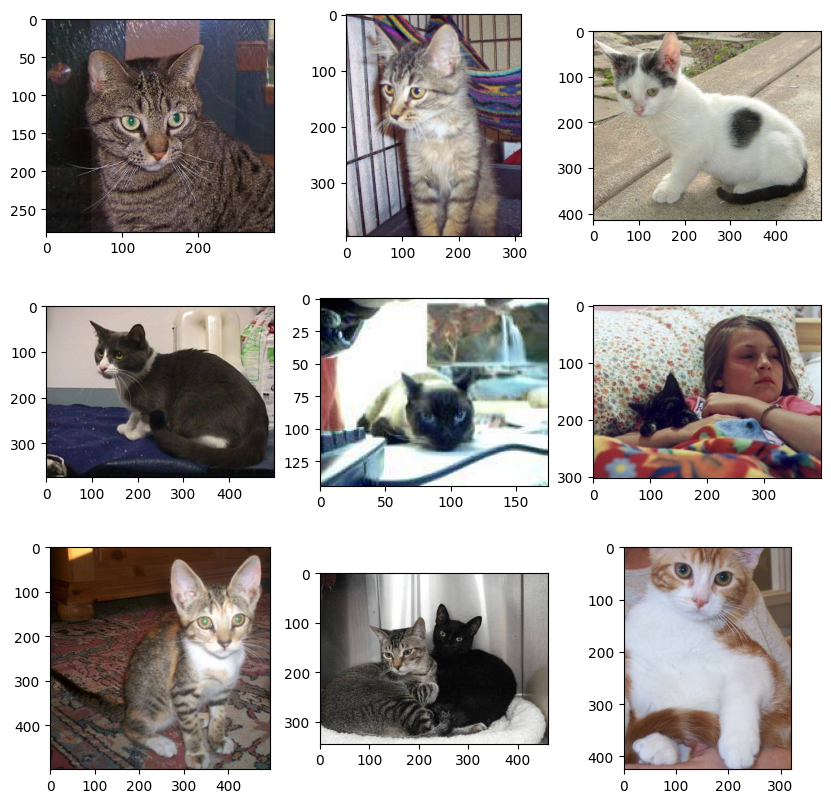

In [0]:
plt.figure(figsize=(10, 10), dpi= 100, facecolor='w', edgecolor='k')
for i in range(1, 10):
    plt.subplot(330+i)
    filename = f"cat.{i}.jpg"
    image = imread(f"{PATH_TO_TRAIN}/{filename}")
    plt.imshow(image)
plt.show()

In [0]:
for dataset_type in ["train", "test", "validation"]:
    for animal_type in ["cats", "dogs"]:
        path=f"{PATH_TO_DATA}/{dataset_type}/{animal_type}"
        if os.path.exists(path):
            rmtree(path)
        makedirs(path, exist_ok=True)
seed(1)
val_ratio = 0.15
test_ratio = 0.15
for file in listdir(PATH_TO_ORIGINAL_TRAIN):
    if file.endswith("jpg"):
        src = f"{PATH_TO_ORIGINAL_TRAIN}/{file}"
        ran_value=random.random()
        if ran_value<test_ratio:
            dst_dir = f"{PATH_TO_DATA}/test"
        elif test_ratio<=ran_value<test_ratio+val_ratio:
            dst_dir = f"{PATH_TO_DATA}/validation"
        else:
            dst_dir = f"{PATH_TO_DATA}/train"
        if file.startswith('cat'):
            dst = f"{dst_dir}/cats/{file}"
            copyfile(src, dst)
        elif file.startswith('dog'):
            dst = f"{dst_dir}/dogs/{file}"
            copyfile(src, dst)

In [0]:
def show_images(before, after, operation):
    plt.figure(figsize=(10, 10), dpi= 100, facecolor='w', edgecolor='k')
    plt.subplot(121)
    plt.imshow(before)
    plt.subplot(122)
    plt.imshow(after)
    plt.title(operation)

In [0]:
def random_affine(image):
    scale_vals=[random.uniform(0.6, 1.4), random.uniform(0.6, 1.4)]
    tform = AffineTransform(scale=(min(scale_vals), max(scale_vals)),
                            rotation=random.uniform(-0.2, 0.2),
                            shear=random.uniform(-0.2, 0.2),
                            translation=(random.uniform(-image.shape[0]//10, image.shape[0]//10), 
                                         random.uniform(-image.shape[1]//10, image.shape[1]//10)))
    return warp(image, tform.inverse, mode='reflect')


def random_perspective(image):
    region = 1/4
    A = np.array([[0, 0], [0, image.shape[0]], [image.shape[1], image.shape[0]], [image.shape[1], 0]])
    B = np.array([[int(random.uniform(0, image.shape[1] * region)), int(random.uniform(0, image.shape[0] * region))], 
                  [int(random.uniform(0, image.shape[1] * region)), int(random.uniform(image.shape[0] * (1-region), image.shape[0]))], 
                  [int(random.uniform(image.shape[1] * (1-region), image.shape[1])), int(random.uniform(image.shape[0] * (1-region), image.shape[0]))], 
                  [int(random.uniform(image.shape[1] * (1-region), image.shape[1])), int(random.uniform(0, image.shape[0] * region))], 
                 ])
    pt = ProjectiveTransform()
    pt.estimate(A, B)
    return warp(image, pt, output_shape=image.shape[:2])


def random_crop(image):
    margin = 1/10
    start = [int(random.uniform(0, image.shape[0] * margin)),
             int(random.uniform(0, image.shape[1] * margin))]
    end = [int(random.uniform(image.shape[0] * (1-margin), image.shape[0])), 
           int(random.uniform(image.shape[1] * (1-margin), image.shape[1]))]
    return image[start[0]:end[0], start[1]:end[1]]


def random_intensity(image):
    return rescale_intensity(image,
                             in_range=tuple(np.percentile(image, (random.uniform(0,10), random.uniform(90,100)))),
                             out_range=tuple(np.percentile(image, (random.uniform(0,10), random.uniform(90,100)))))

def random_gamma(image):
    return adjust_gamma(image, gamma=random.uniform(0.5, 1.5))

def random_gaussian(image):
    return img_as_float64(gaussian(image, sigma=random.uniform(0.5, 3), multichannel=True, mode='reflect'))
    
def random_filter(image):
    Filters = [equalize_adapthist, equalize_hist, adjust_log, adjust_sigmoid, random_gamma, random_gaussian, random_intensity]
    filt = random.choice(Filters)
    return filt(image)


def random_noise_img(image):
    var = random.uniform(0.001, 0.01)
    return ski_random_noise(image, var=var)


In [0]:
image_to_transform = skimage.io.imread(f"{PATH_TO_TRAIN}/cat.90.jpg")

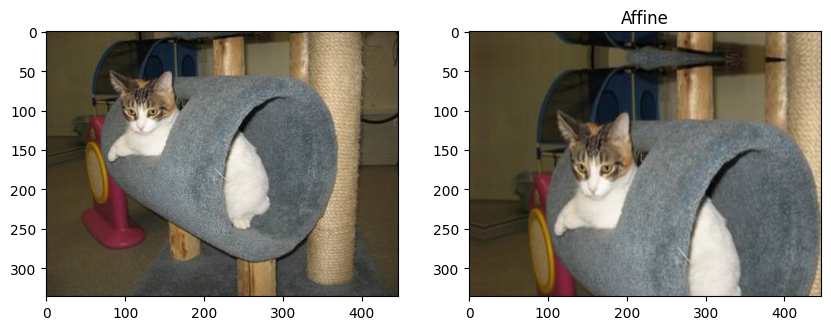

In [0]:
show_images(image_to_transform, random_affine(image_to_transform), "Affine")

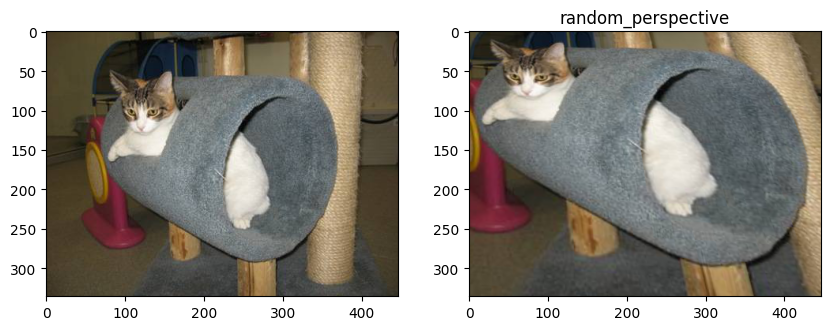

In [0]:
show_images(image_to_transform, random_perspective(image_to_transform), "random_perspective")

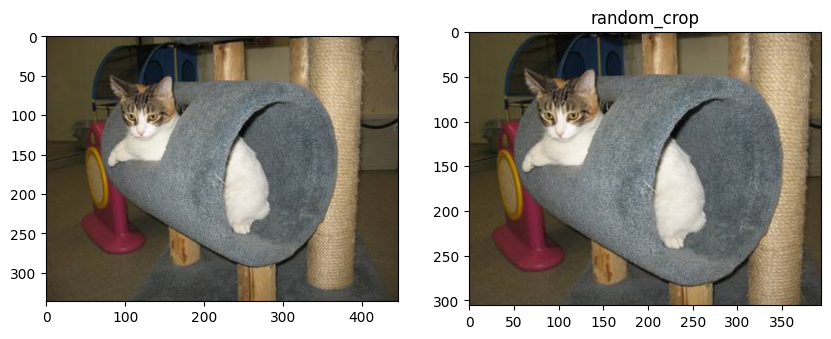

In [0]:
show_images(image_to_transform, random_crop(image_to_transform), "random_crop")

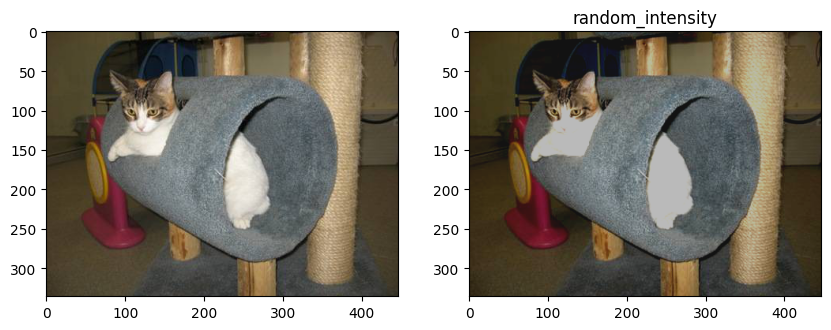

In [0]:
show_images(image_to_transform, random_intensity(image_to_transform), "random_intensity")

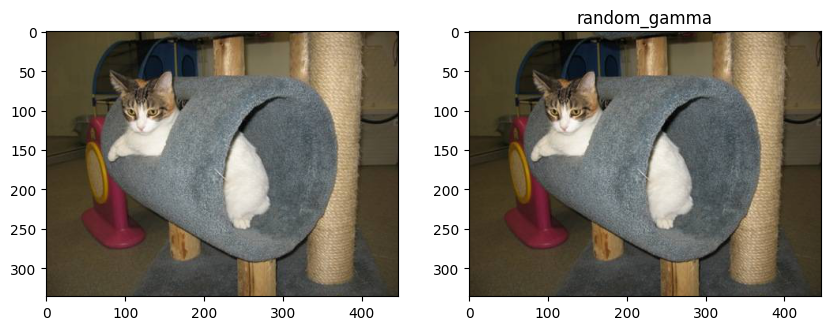

In [0]:
show_images(image_to_transform, random_gamma(image_to_transform), "random_gamma")

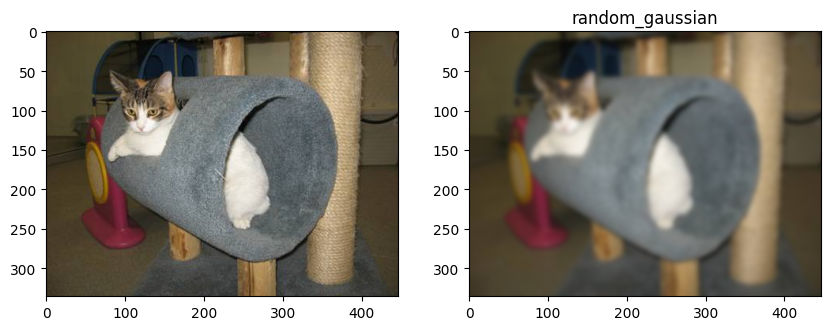

In [0]:
show_images(image_to_transform, random_gaussian(image_to_transform), "random_gaussian")

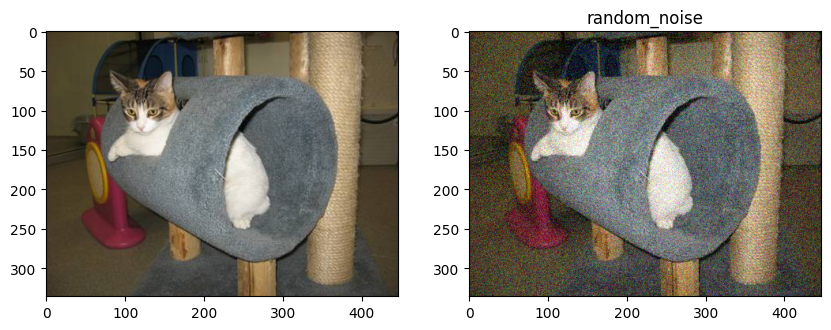

In [0]:
show_images(image_to_transform, random_noise_img(image_to_transform), "random_noise")

In [0]:
def create_3_level_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [0]:
def plot_history(history):
    plt.figure(figsize=(10, 10), dpi= 100, facecolor='w', edgecolor='k')
    plt.subplot(211)
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.subplot(212)
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()

In [0]:
def evaluate_model(model, train_datagen, validation_datagen, test_datagen, target_size=(200, 200), epochs=50, batch_size=64, early_stopping=None):
    train_it = train_datagen.flow_from_directory(f"{PATH_TO_DATA}/train", class_mode='binary', batch_size=batch_size, target_size=target_size, classes=["dogs", "cats"])
    validation_it = validation_datagen.flow_from_directory(f"{PATH_TO_DATA}/validation", class_mode='binary', batch_size=batch_size, target_size=target_size, classes=["dogs", "cats"])
    test_it = test_datagen.flow_from_directory(f"{PATH_TO_DATA}/test", class_mode='binary', batch_size=batch_size, target_size=target_size, classes=["dogs", "cats"])
    callbacks=[]
    if early_stopping:
        callbacks.append(early_stopping)
    else:
        callbacks.append(EarlyStopping(monitor='val_accuracy', mode='max', patience=5))
    history = model.fit(train_it, steps_per_epoch=len(train_it), epochs=epochs, verbose=1, validation_data=validation_it, validation_steps=len(validation_it), callbacks=callbacks)
    loss, accuracy= model.evaluate(test_it, steps=len(test_it), verbose=1)
    print(f"Model loss={loss}, accuracy={accuracy}")
    return history

In [0]:
rescale_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [0]:
model_1 = create_3_level_model()
history=evaluate_model(model_1, rescale_datagen, rescale_datagen, rescale_datagen, epochs=50)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 46, 46, 128)      

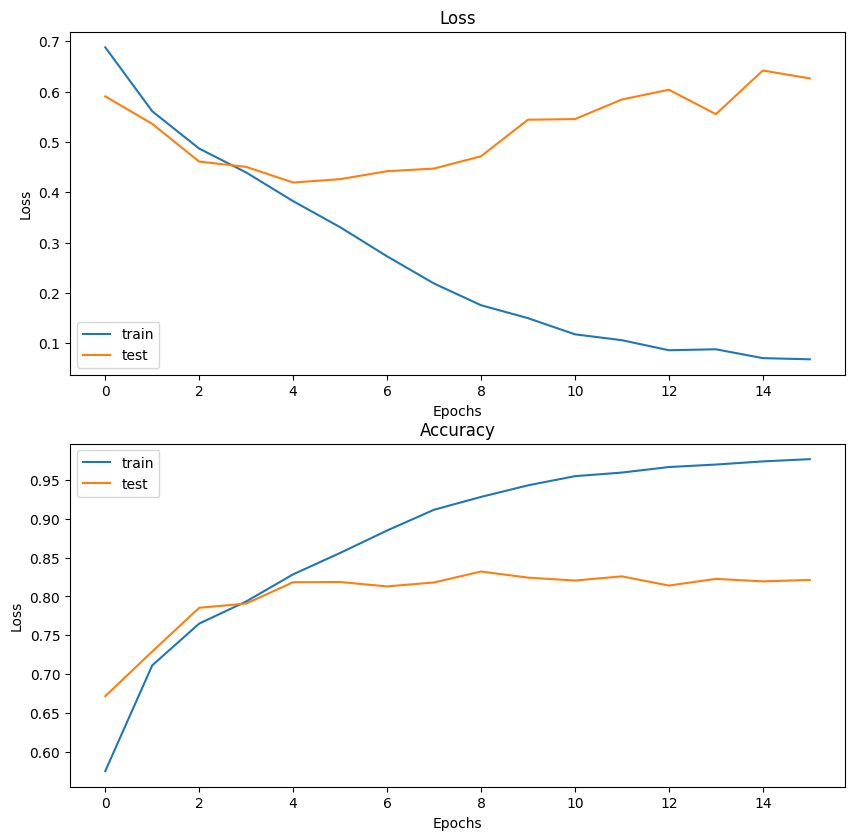

In [0]:
plot_history(history)

In [0]:
for animal_type in ["cats", "dogs"]:
    path=f"{PATH_TO_TRAIN}/augmented_{animal_type}"
    if os.path.exists(path):
        rmtree(path)
    makedirs(path, exist_ok=True)
for animal_type in ["cats", "dogs"]:
    all_images_path=f"{PATH_TO_TRAIN}/{animal_type}"
    augmented_path=f'{PATH_TO_TRAIN}/augmented_{animal_type}'
    for file in listdir(all_images_path):
        image_to_transform = skimage.io.imread(f"{all_images_path}/{file}")
        for idx, transformation_f in enumerate([random_affine, random_perspective, random_crop, random_intensity, random_gaussian, random_noise_img]):
            transformed_image = transformation_f(image_to_transform)
            new_file_path = f'{augmented_path}/augmented_image_{idx}_{file}.jpg'
            try:
              skimage.io.imsave(new_file_path, img_as_ubyte(transformed_image))
            except Exception as exc:
              try:
                transformed_image=rescale_intensity(transformed_image,( -1, 1))
                skimage.io.imsave(new_file_path, img_as_ubyte(transformed_image))
              except Exception as exc:
                print(exc)
                print(str(transformation_f))
    for file in listdir(f"{augmented_path}"):
        copyfile(f"{augmented_path}/{file}", f"{all_images_path}/{file}")
    rmtree(augmented_path)
    files_iter=listdir(f"{all_images_path}")
    print(f"Total quantity of files for animal {animal_type}: {len(files_iter)}")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: dogs-vs-cats/train/augmented_cats/augmented_image_3_cat.10029.jpg.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: dogs-vs-cats/train/augmented_cats/augmented_image_3_cat.8456.jpg.jpg is a low contrast image
  from ipykernel import kernelapp as app


Total quantity of files for animal cats: 60949


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: dogs-vs-cats/train/augmented_dogs/augmented_image_3_dog.8736.jpg.jpg is a low contrast image
  from ipykernel import kernelapp as app


Total quantity of files for animal dogs: 61516


In [0]:
model_2 = create_3_level_model()
history=evaluate_model(model_2, rescale_datagen, rescale_datagen, rescale_datagen, epochs=50)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 128)       7

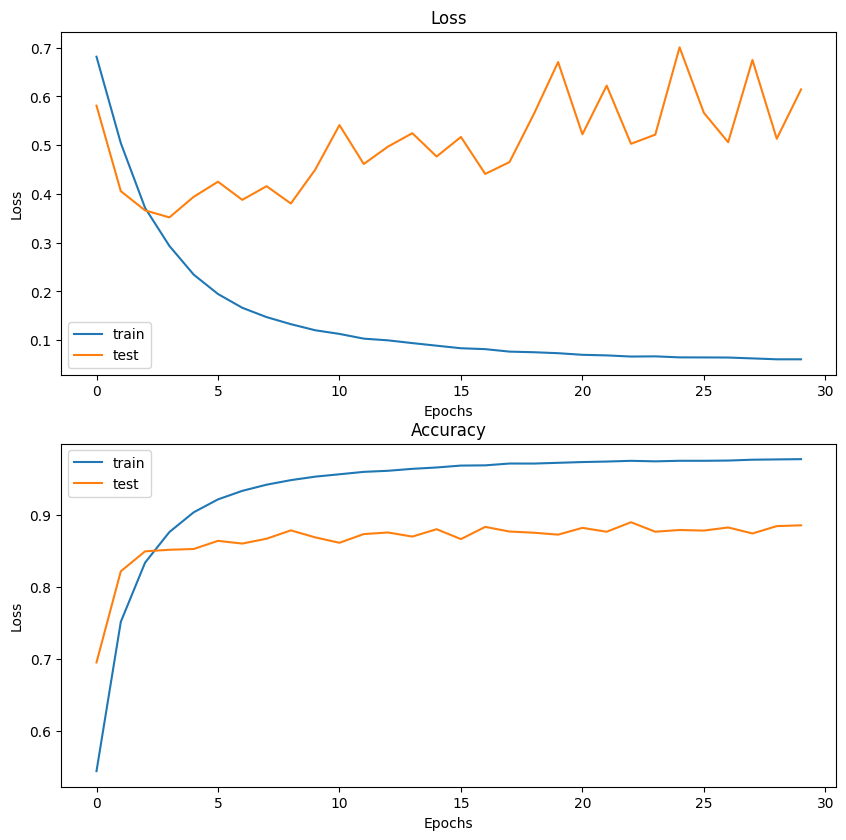

In [0]:
plot_history(history)

In [0]:
def add_fully_connected_layers(pre_trainded_model):
    for layer in pre_trainded_model.layers:
        layer.trainable = False
    x = Flatten()(pre_trainded_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=pre_trainded_model.input, outputs=x)
    opt = RMSprop(lr=0.0001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [0]:
train_datagen_augmentation = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [0]:
model_vgg = add_fully_connected_layers(VGG16(include_top=False, input_shape=(224, 224, 3)))
history=evaluate_model(model_vgg, train_datagen_augmentation, test_datagen, test_datagen, target_size=(224, 224), epochs=50,
                       early_stopping=EarlyStopping(patience=10, monitor='val_loss', min_delta=0, mode='min'))

Found 122465 images belonging to 2 classes.
Found 3704 images belonging to 2 classes.
Found 3801 images belonging to 2 classes.
Epoch 1/50
1914/1914 [==============================] - 780s 407ms/step - loss: 0.2653 - accuracy: 0.8846 - val_loss: 0.1581 - val_accuracy: 0.9384
Epoch 2/50
1914/1914 [==============================] - 783s 409ms/step - loss: 0.1539 - accuracy: 0.9366 - val_loss: 0.1697 - val_accuracy: 0.9371
Epoch 3/50
1914/1914 [==============================] - 783s 409ms/step - loss: 0.1106 - accuracy: 0.9569 - val_loss: 0.2889 - val_accuracy: 0.9141
Epoch 4/50
1914/1914 [==============================] - 783s 409ms/step - loss: 0.0826 - accuracy: 0.9694 - val_loss: 0.1995 - val_accuracy: 0.9371
Epoch 5/50
1914/1914 [==============================] - 782s 409ms/step - loss: 0.0630 - accuracy: 0.9772 - val_loss: 0.2196 - val_accuracy: 0.9414
Epoch 6/50
1914/1914 [==============================] - 782s 409ms/step - loss: 0.0496 - accuracy: 0.9826 - val_loss: 0.2554 - val_a

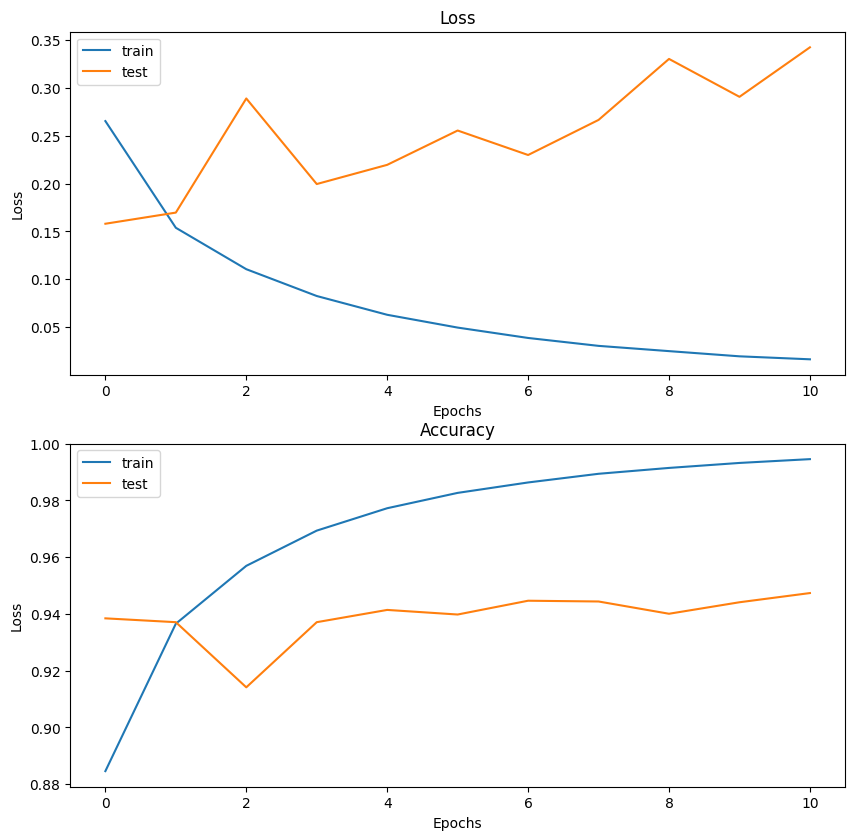

In [0]:
plot_history(history)

In [0]:
model_resnet=add_fully_connected_layers(ResNet50V2(include_top=False, input_shape=(224, 224, 3)))
history=evaluate_model(model_resnet, train_datagen_augmentation, test_datagen, test_datagen, target_size=(224, 224), epochs=50,
                       early_stopping=EarlyStopping(patience=5, monitor='val_loss', min_delta=0, mode='min'))

Found 122465 images belonging to 2 classes.
Found 3704 images belonging to 2 classes.
Found 3801 images belonging to 2 classes.
Epoch 1/50
1914/1914 [==============================] - 463s 242ms/step - loss: 0.1076 - accuracy: 0.9821 - val_loss: 0.1249 - val_accuracy: 0.9852
Epoch 2/50
1914/1914 [==============================] - 443s 231ms/step - loss: 0.0310 - accuracy: 0.9948 - val_loss: 0.1447 - val_accuracy: 0.9868
Epoch 3/50
1914/1914 [==============================] - 449s 235ms/step - loss: 0.0108 - accuracy: 0.9983 - val_loss: 0.1885 - val_accuracy: 0.9860
Epoch 4/50
1914/1914 [==============================] - 453s 237ms/step - loss: 0.0040 - accuracy: 0.9993 - val_loss: 0.2086 - val_accuracy: 0.9852
Epoch 5/50
1914/1914 [==============================] - 454s 237ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 0.2169 - val_accuracy: 0.9862
Epoch 6/50
60/60 [==============================] - 14s 236ms/step - loss: 0.2578 - accuracy: 0.9868
Model loss=0.25781095027923584,

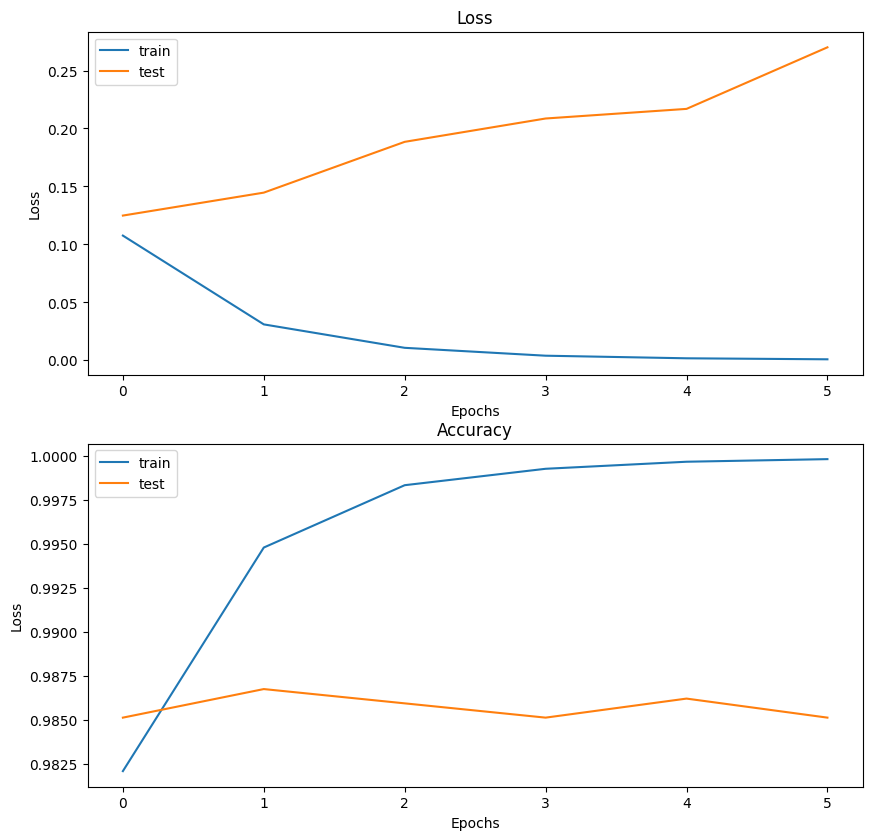

In [0]:
plot_history(history)

In [0]:
model_inception=add_fully_connected_layers(InceptionV3(include_top=False, input_shape=(299, 299, 3)))
history=evaluate_model(model_inception, train_datagen_augmentation, test_datagen, test_datagen, target_size=(299, 299), epochs=50,
                       early_stopping=EarlyStopping(patience=5, monitor='val_loss', min_delta=0, mode='min'))

87916544/87910968 [==============================] - 1s 0us/step
Found 122465 images belonging to 2 classes.
Found 3704 images belonging to 2 classes.
Found 3801 images belonging to 2 classes.
Epoch 1/50
1914/1914 [==============================] - 564s 295ms/step - loss: 0.1436 - accuracy: 0.9819 - val_loss: 0.0568 - val_accuracy: 0.9911
Epoch 2/50
1914/1914 [==============================] - 583s 305ms/step - loss: 0.0521 - accuracy: 0.9917 - val_loss: 0.0792 - val_accuracy: 0.9892
Epoch 3/50
1914/1914 [==============================] - 569s 298ms/step - loss: 0.0308 - accuracy: 0.9951 - val_loss: 0.0855 - val_accuracy: 0.9908
Epoch 4/50
1914/1914 [==============================] - 558s 291ms/step - loss: 0.0239 - accuracy: 0.9964 - val_loss: 0.0546 - val_accuracy: 0.9930
Epoch 5/50
1914/1914 [==============================] - 552s 288ms/step - loss: 0.0156 - accuracy: 0.9977 - val_loss: 0.0576 - val_accuracy: 0.9954
Epoch 6/50
1914/1914 [==============================] - 554s 289ms/

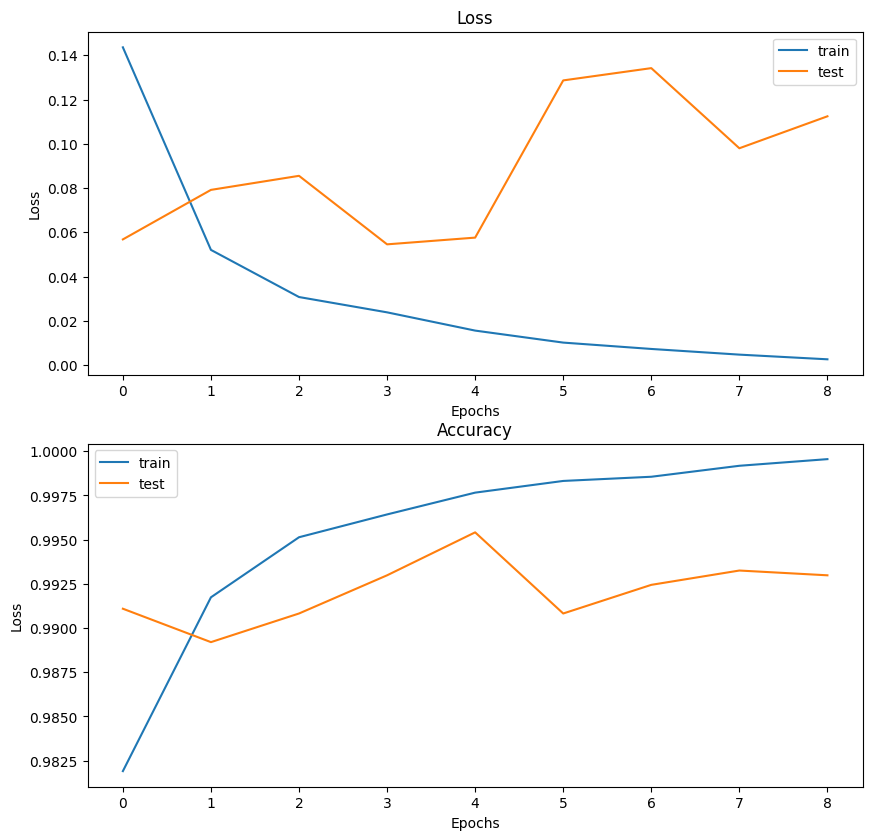

In [0]:
plot_history(history)

In [0]:
model_inception_resnet=add_fully_connected_layers(InceptionResNetV2(include_top=False, input_shape=(299, 299, 3)))
history=evaluate_model(model_inception_resnet, train_datagen_augmentation, test_datagen, test_datagen, target_size=(299, 299), epochs=50,
                       early_stopping=EarlyStopping(patience=5, monitor='val_loss', min_delta=0, mode='min'))

219062272/219055592 [==============================] - 2s 0us/step
Found 122465 images belonging to 2 classes.
Found 3704 images belonging to 2 classes.
Found 3801 images belonging to 2 classes.
Epoch 1/50
1914/1914 [==============================] - 711s 372ms/step - loss: 0.1279 - accuracy: 0.9874 - val_loss: 0.0540 - val_accuracy: 0.9941
Epoch 2/50
1914/1914 [==============================] - 708s 370ms/step - loss: 0.0543 - accuracy: 0.9936 - val_loss: 0.0979 - val_accuracy: 0.9930
Epoch 3/50
1914/1914 [==============================] - 708s 370ms/step - loss: 0.0396 - accuracy: 0.9960 - val_loss: 0.0754 - val_accuracy: 0.9943
Epoch 4/50
1914/1914 [==============================] - 707s 370ms/step - loss: 0.0243 - accuracy: 0.9974 - val_loss: 0.1185 - val_accuracy: 0.9943
Epoch 5/50
1914/1914 [==============================] - 707s 369ms/step - loss: 0.0178 - accuracy: 0.9980 - val_loss: 0.0869 - val_accuracy: 0.9960
Epoch 6/50
60/60 [==============================] - 20s 340ms/ste

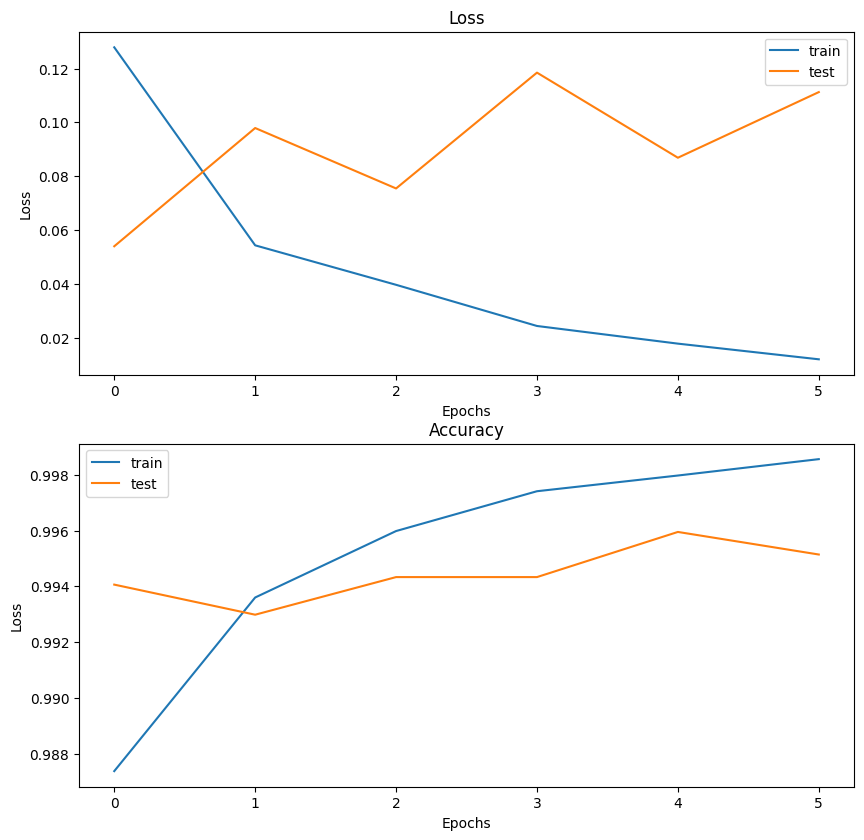

In [0]:
plot_history(history)